# Machine Learning Exercise 12

# AlexNet-like model for ARGOS


##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("tf.Keras version %s" %tf.keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.7.0
Keras version 2.7.0
Found GPU at: /device:GPU:0


## Load data

Get data from  
https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M?resourcekey=0-RKOYOxuHZTxh0eSZRSnIoA

Place data in a Google folder and set the `datadir` variable below with the path of this folder.

Get Google Drive access

Load training data

4774 images from 20 classes



In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/MyDrive/Data/ARGOS_public'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Mounted at /content/drive
Found 4774 images belonging to 20 classes.
Found 1686 images belonging to 20 classes.
Image input (118, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4774 training samples from 20 classes.
Loaded 1686 test samples from 20 classes.


##Show *n* random images


Acqua


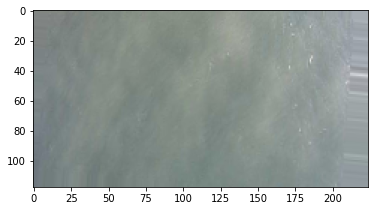

Mototopo


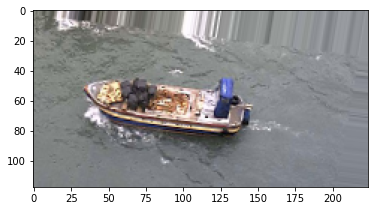

Motobarca


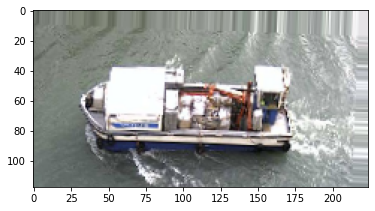

In [ ]:
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
    
    


##AlexNet

Create a new model inspired by AlexNet.

Note: if you want to load a pre-trained model on this dataset, go to next section.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

###Load a trained model

Load a model already trained on this data set (i.e., saved with save function show in the next section).

In [ ]:
import os
import pickle
from tensorflow.keras.models import load_model

models_dir = datadir + '/models/'
loadepochs = 50
modelname = 'ARGOS-sc5-2013_20classes_alexnet_%d_epochs' %loadepochs

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    try:
        history = pickle.load(open(filename, "rb"))
        print("History loaded successfully from file %s\n" %filename)
    except OSError as e:
        print(e)
        print("History file %s not found!!!\n" %filename)
        history = None
    return model, history

model, history = loadmodel(modelname)


Model loaded successfully from file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_40_epochs.h5

History loaded successfully from file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_40_epochs_history.pkl



## Train

With GPU, training for 100 epochs takes about 2.5 hours, including model building and other initialization of the data generator happening in the first epoch.

Note: first epoch takes much longer for initialization and caching.

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 10  # sets number of epochs

try:
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

# append current history

if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])


Epoch 1/10
149/149 [==============================] - 70s 460ms/step - loss: 0.9106 - accuracy: 0.8876 - val_loss: 1.2841 - val_accuracy: 0.8084
Epoch 2/10
149/149 [==============================] - 68s 457ms/step - loss: 0.8941 - accuracy: 0.8884 - val_loss: 1.0393 - val_accuracy: 0.8719
Epoch 3/10
149/149 [==============================] - 68s 459ms/step - loss: 0.8893 - accuracy: 0.8887 - val_loss: 1.1091 - val_accuracy: 0.8523
Epoch 4/10
149/149 [==============================] - 67s 450ms/step - loss: 0.8575 - accuracy: 0.9036 - val_loss: 1.1262 - val_accuracy: 0.8600
Epoch 5/10
149/149 [==============================] - 68s 453ms/step - loss: 0.8500 - accuracy: 0.9011 - val_loss: 1.2154 - val_accuracy: 0.8399
Epoch 6/10
149/149 [==============================] - 68s 459ms/step - loss: 0.8639 - accuracy: 0.8967 - val_loss: 1.5182 - val_accuracy: 0.7610
Epoch 7/10
149/149 [==============================] - 68s 460ms/step - loss: 0.8375 - accuracy: 0.9028 - val_loss: 1.0759 - val_ac

###Save model and history

In [ ]:
import os
import pickle

models_dir = datadir + '/models/'
modelname = 'ARGOS-sc5-2013_20classes_alexnet_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model,history)



Model saved successfully on file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs.h5

History saved successfully on file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs_history.pkl



##Evaluate the model

Accuracy on test set

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Found 1686 images belonging to 20 classes.
53/53 [==============================] - 12s 221ms/step - loss: 1.2650 - accuracy: 0.8209
Test loss: 1.264993
Test accuracy: 0.820878


Precision, recall, F-score

In [ ]:

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 10s 192ms/step
                         precision    recall  f1-score   support

                  Acqua      0.989     0.876     0.929       420
              Alilaguna      0.600     0.947     0.735        19
              Ambulanza      0.800     0.727     0.762        22
               Barchino      0.600     0.059     0.107        51
            Cacciapesca      0.000     0.000     0.000         1
               Caorlina      0.000     0.000     0.000         1
                Gondola      0.000     0.000     0.000         3
                 Lancia      0.810     0.938     0.869       355
              Motobarca      0.339     0.661     0.448        59
Motopontonerettangolare      0.600     1.000     0.750         3
          MotoscafoACTV      1.000     1.000     1.000         1
               Mototopo      0.921     0.743     0.823       284
              Patanella      0.465     0.811     0.591 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix analysis

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 1686 images belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


53/53 [==============================] - 10s 191ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Mototopo         ->  Motobarca         	61 	3.62 % 
Acqua            ->  Lancia            	23 	1.36 % 
Topa             ->  Patanella         	20 	1.19 % 
Barchino         ->  Patanella         	19 	1.13 % 
Acqua            ->  Patanella         	15 	0.89 % 
Barchino         ->  Lancia            	14 	0.83 % 
Patanella        ->  Lancia            	10 	0.59 % 
Motobarca        ->  Lancia            	9 	0.53 % 
Raccoltarifiuti  ->  Motobarca         	9 	0.53 % 
Lancia           ->  VigilidelFuoco    	6 	0.36 % 
Motobarca        ->  Patanella         	6 	0.36 % 
Mototopo         ->  Alilaguna         	6 	0.36 % 
Barchino         ->  Cacciapesca       	6 	0.36 % 
Topa             ->  Lancia            	6 	0.36 % 
Polizia          ->  Lancia            	5 	0.30 % 
Barchino         ->  Polizia           	5 	0.30 % 

### Plot results

Expected results with 100 epochs training

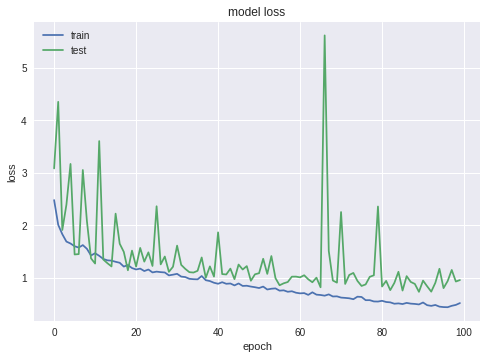



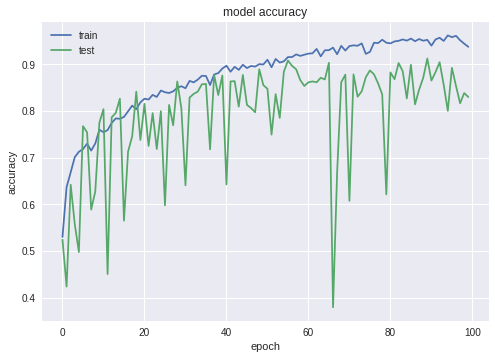



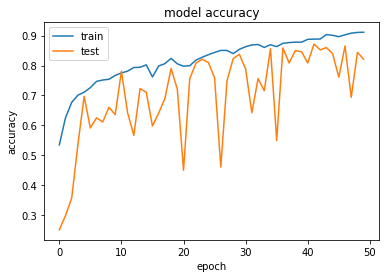

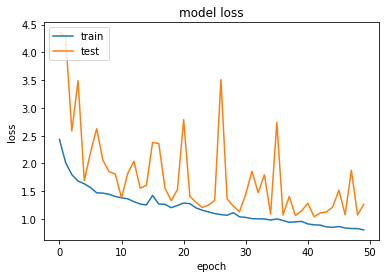

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Home Exercises

**Question 1** 

Compare the model defined above with a model without all the regularization additions.
